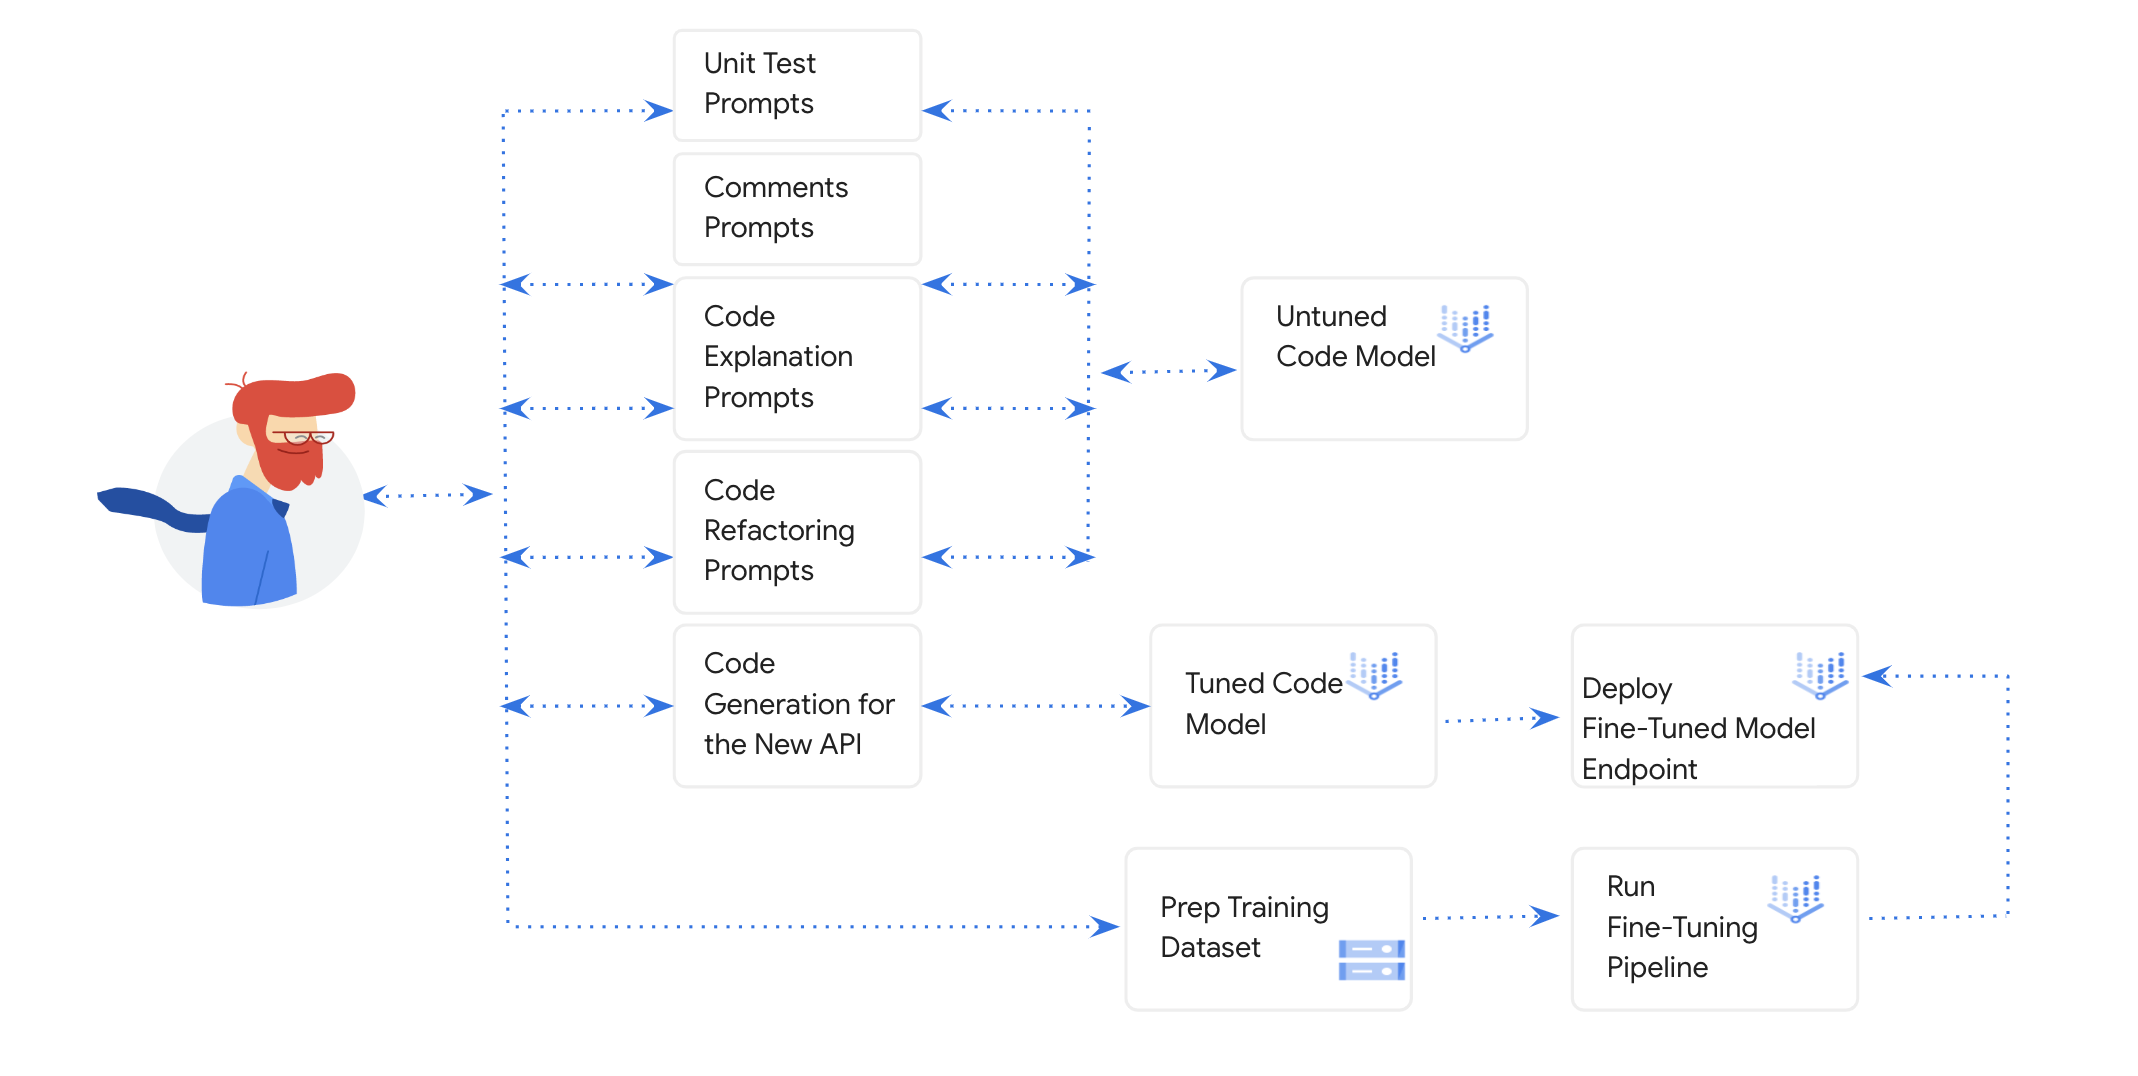


* Author: [leip@](https://moma.corp.google.com/person/leip)
* Date: 10/27/23

## Overview

Codey models are text-to-code models from Google AI, trained on a massive code related dataset. You can generate code related responses for different scenarios such as writing functions, unit tests, debugging, autocompleting and etc. This notebook is to show you how to use Codey APIs to do tasks below.

User Journey 1.2: Generate code for custom libraries based on org private repo, new languages, and new code patterns

- Generate functions
- Explain code
- Generate unit tests
- Generate comment
- Assisted code refactoring/modification


## Pre Work

In [ ]:
# @title Install Libraries
import sys
if 'google.colab' in sys.modules:
    ! pip install google-cloud-aiplatform
    ! pip install google-cloud-discoveryengine
    ! pip install jsonlines
    from google.colab import auth as google_auth
    google_auth.authenticate_user()

In [ ]:
import sys
import json
import os
import vertexai
from typing import Dict, List, Optional, Tuple
from google.cloud import discoveryengine
from google.protobuf.json_format import MessageToDict

In [ ]:
# @title Initialize Vertex AI
import vertexai
from vertexai.preview.language_models import CodeGenerationModel

VERTEX_API_PROJECT = '<your project>'
VERTEX_API_LOCATION = '<location>'

vertexai.init(project=VERTEX_API_PROJECT, location=VERTEX_API_LOCATION)
code_generation_model = CodeGenerationModel.from_pretrained("code-bison@001")

def send_prompt(prefix, max_token=1024, model = code_generation_model):
    parameters = {
    "temperature": 0.2,
    "max_output_tokens": max_token
    }

    response = model.predict(
    prefix=prefix, **parameters
    )

    return response.text

In [ ]:
# @title Set Up Vertex AI Search API Parameters
project_id = "<project id>"
location = "<location>"
search_engine_id = "<search engine id of the vertex AI search API>"
serving_config_id = "<search config id of the vertex AI search API> - usually it's default"

## Fine-Tune Codey Model to Learna New API

In [ ]:
# @title Step 1: Generate Vertex AI Search API Code using Untuned Codey Model
prompt = """
Generate a function to send search queries to the Vertex AI Search API and retrieve the search results.
"""
print(send_prompt (prompt))

```python
def search_vertex_ai(query):

  # Create a client for the Vertex AI Search API.
  client = VertexAiSearchClient()

  # Create a search request.
  request = SearchRequest()
  request.query = query

  # Send the search request.
  response = client.search(request)

  # Get the search results.
  results = response.results

  # Return the search results.
  return results
```


In [ ]:
# @title Step 2: Tune Model to Understand the Latest Vertex AI Search API
model = CodeGenerationModel.from_pretrained("code-bison@001")

training_dataset_url = "<dataset URL - gcs bucket>"
model.tune_model(
    training_data=training_dataset_url,
    train_steps=200,
    tuning_job_location="<job location>",
    tuned_model_location="<model location>",
    model_display_name="<display name>"
    )

In [ ]:
# @title Step 3: Query Tuned Model to Generate Vertext AI Search Code
list_models = CodeGenerationModel.from_pretrained("code-bison@001").list_tuned_model_names()
TUNED_MODEL_NAME = list_models[0]
tuned_model = CodeGenerationModel.get_tuned_model(TUNED_MODEL_NAME)
vertexai_search_code = send_prompt(prefix=prompt,model= tuned_model)
vertexai_search_code = vertexai_search_code.removeprefix(' ```python').removesuffix('```')
print(vertexai_search_code)

```python
def search_sample(
    project_id: str,
    location: str,
    search_engine_id: str,
    serving_config_id: str,
    search_query: str,
) -> List[discoveryengine.SearchResponse.SearchResult]:
    client = discoveryengine.SearchServiceClient()
    serving_config = client.serving_config_path(
        project=project_id,
        location=location,
        data_store=search_engine_id,
        serving_config=serving_config_id,
    )

    request = discoveryengine.SearchRequest(
        serving_config=serving_config,
        query=search_query,
    )
    response = client.search(request)

    return response



In [ ]:
# @title Step 4: Use the Generated Code to Query Vertex Search Engine
def search_sample(
    project_id: str,
    location: str,
    search_engine_id: str,
    serving_config_id: str,
    search_query: str,
) -> List[discoveryengine.SearchResponse.SearchResult]:
    client = discoveryengine.SearchServiceClient()
    serving_config = client.serving_config_path(
        project=project_id,
        location=location,
        data_store=search_engine_id,
        serving_config=serving_config_id,
    )

    request = discoveryengine.SearchRequest(
        serving_config=serving_config,
        query=search_query,
    )
    response = client.search(request)

    return response

In [ ]:
search_query = "how to improve campaign performance"
results = search_sample(project_id,location,search_engine_id,serving_config_id,search_query)
print(results)

SearchPager<results {
  id: "0"
  document {
    name: "projects/1062767160769/locations/global/collections/default_collection/dataStores/ad-help_1688047621201/branches/0/documents/0"
    id: "0"
    derived_struct_data {
      fields {
        key: "displayLink"
        value {
          string_value: "support.google.com"
        }
      }
      fields {
        key: "formattedUrl"
        value {
          string_value: "https://support.google.com/google-ads/answer/10724817?hl=en"
        }
      }
      fields {
        key: "htmlFormattedUrl"
        value {
          string_value: "https://support.google.com/google-ads/answer/10724817?hl=en"
        }
      }
      fields {
        key: "htmlTitle"
        value {
          string_value: "About <b>Performance</b> Max <b>campaigns</b> - Google Ads Help"
        }
      }
      fields {
        key: "link"
        value {
          string_value: "https://support.google.com/google-ads/answer/10724817?hl=en"
        }
      }
      fi

In [ ]:
# @title Step 5: Modify Generated Code with Protobuf Parsing Code
proto_prompt = """
Create a function to send search requests to Vertex AI Search API, convert the protobuf search response to a dictionary, and return the dictionary result.
"""
vertexai_search_code = send_prompt(prefix=proto_prompt,model= tuned_model)
vertexai_search_code = vertexai_search_code.removeprefix(' ```python').removesuffix('```')
print(vertexai_search_code)

```python
def search_sample(
    project_id: str,
    location: str,
    search_engine_id: str,
    serving_config_id: str,
    search_query: str,
) -> List[discoveryengine.SearchResponse.SearchResult]:
    client = discoveryengine.SearchServiceClient()
    serving_config = client.serving_config_path(
        project=project_id,
        location=location,
        data_store=search_engine_id,
        serving_config=serving_config_id,
    )

    request = discoveryengine.SearchRequest(
        serving_config=serving_config,
        query=search_query,
    )
    response = client.search(request)
    results = [MessageToDict(result.document._pb) for result in response.results]

    return results



In [ ]:
# @title Step 6: Use the Generated Code to Query Vertex Search Engine
def search_sample(
    project_id: str,
    location: str,
    search_engine_id: str,
    serving_config_id: str,
    search_query: str,
) -> List[discoveryengine.SearchResponse.SearchResult]:
    client = discoveryengine.SearchServiceClient()
    serving_config = client.serving_config_path(
        project=project_id,
        location=location,
        data_store=search_engine_id,
        serving_config=serving_config_id,
    )

    request = discoveryengine.SearchRequest(
        serving_config=serving_config,
        query=search_query,
    )
    response = client.search(request)
    results = [MessageToDict(result.document._pb) for result in response.results]

    return results


search_query = "how to improve campaign performance"
results = search_sample(project_id,location,search_engine_id,serving_config_id,search_query)

for result in results:
  print(result['derivedStructData']['title'])
  print(result['derivedStructData']['link'])

About Performance Max campaigns - Google Ads Help
https://support.google.com/google-ads/answer/10724817?hl=en
Improve your Smart campaign's performance - Google Ads Help
https://support.google.com/google-ads/answer/7653465?hl=en
Upgrade your display campaigns to Performance Max campaigns ...
https://support.google.com/google-ads/answer/13451710?hl=en-GB
About conversion goals - Google Ads Help
https://support.google.com/google-ads/answer/10995103?hl=en
Optimization tips for Performance Max campaign for all business ...
https://support.google.com/google-ads/answer/11385582?hl=en
Boost your Search and Display results in Performance Max campaigns
https://support.google.com/google-ads/answer/13780156?hl=en
Reminder: Upgrade your Smart Shopping campaigns to ...
https://support.google.com/google-ads/answer/12368488?hl=en
About asset reporting in Performance Max - Google Ads Help
https://support.google.com/google-ads/answer/10725056?hl=en
5 ways to use Quality Score to improve your performanc

In [ ]:
# @title Step 7: Generate Unit Test
unit_test_prompt = f"""
Generate unit test to cover this block of code {vertexai_search_code}
"""
print(send_prompt (prefix=unit_test_prompt))

```python
import unittest

from google.cloud import discoveryengine
from google.protobuf import json_format


class TestSearchSample(unittest.TestCase):

    def test_search_sample(self):
        project_id = "my-project"
        location = "us-central1"
        search_engine_id = "my-search-engine"
        serving_config_id = "my-serving-config"
        search_query = "hello world"

        results = search_sample(
            project_id=project_id,
            location=location,
            search_engine_id=search_engine_id,
            serving_config_id=serving_config_id,
            search_query=search_query,
        )

        self.assertIsNotNone(results)
        self.assertIsInstance(results, list)
        self.assertGreater(len(results), 0)

        for result in results:
            self.assertIsNotNone(result)
            self.assertIsInstance(result, discoveryengine.SearchResponse.SearchResult)
            self.assertIsNotNone(result.document)
            self.assertIsInstan

In [ ]:
# @title Step 8: Explain the Code
explain_prompt = f"""
Explain this block of code {vertexai_search_code} line by line
"""
print(send_prompt (prefix=explain_prompt))

The function `search_sample` takes five arguments:

  * `project_id`: The ID of the project that the search engine belongs to.
  * `location`: The location of the search engine.
  * `search_engine_id`: The ID of the search engine.
  * `serving_config_id`: The ID of the serving configuration to use.
  * `search_query`: The search query to use.

The function first creates a client for the Discovery Engine API. It then uses
the client to create a `serving_config` object, which specifies the project,
location, search engine ID, and serving configuration ID.

The function then creates a `SearchRequest` object, which specifies the
`serving_config` and the search query. It then sends the request to the
Discovery Engine API and gets a `SearchResponse` object in return.

The function then iterates over the `results` field of the `SearchResponse`
object and converts each result to a dictionary. It then returns the list of
dictionaries.

Here is a more detailed explanation of each line of code:



In [ ]:
# @title Step 9: Refactor the Code
refactor_prompt = f"""
Refactor this block of code {vertexai_search_code} by using descriptive and meaningful names and comments
"""
print(send_prompt(prefix=refactor_prompt))

```python
def search_sample(
    project_id: str,
    location: str,
    search_engine_id: str,
    serving_config_id: str,
    search_query: str,
) -> List[discoveryengine.SearchResponse.SearchResult]:
    """
    Searches for results in the given search engine.

    Args:
        project_id: The ID of the project that owns the search engine.
        location: The location of the search engine.
        search_engine_id: The ID of the search engine.
        serving_config_id: The ID of the serving config to use.
        search_query: The query to search for.

    Returns:
        A list of search results.
    """

    client = discoveryengine.SearchServiceClient()
    serving_config = client.serving_config_path(
        project=project_id,
        location=location,
        data_store=search_engine_id,
        serving_config=serving_config_id,
    )

    request = discoveryengine.SearchRequest(
        serving_config=serving_config,
        query=search_query,
    )
    response = clie

In [ ]:
# @title Step 10: Generate Comments
comment_prompt = f"""
Generate line-by-line comments for this block of code {vertexai_search_code}
"""
print(send_prompt (prefix=comment_prompt))

This function performs a search using the Discovery Engine API.

The function takes four arguments:

* `project_id`: The ID of the project that the search engine belongs to.
* `location`: The location of the search engine.
* `search_engine_id`: The ID of the search engine.
* `serving_config_id`: The ID of the serving configuration to use for the search.

The function returns a list of `SearchResult` objects, which contain information about the documents that were found in the search.

Here is a more detailed explanation of each line of code:

* `client = discoveryengine.SearchServiceClient()`: This creates a client object for the Discovery Engine API.
* `serving_config = client.serving_config_path(project=project_id, location=location, data_store=search_engine_id, serving_config=serving_config_id)`: This constructs the path to the serving configuration to use for the search.
* `request = discoveryengine.SearchRequest(serving_config=serving_config, query=search_query)`: This creates a `